In [1]:
%matplotlib ipympl

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from obspy import read_inventory, read, UTCDateTime
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
from matplotlib.widgets import Button
from functools import partial
from collections import defaultdict
import os, glob, warnings, math
warnings.filterwarnings("ignore")

# Functions

In [4]:
# FFT
def calc_fft(data,npts,sr):
	'''
	data: time series signal
	npts: number of points in time series
	sr: sampling rate
	'''
	Fdat = np.fft.fft(data,npts)
	freq = np.fft.fftfreq(npts, d=1./sr)
	return Fdat, freq #2.0/sr * np.abs(Fdat)  np.abs(Fdat) 

#iFFT
def calc_ifft(data):
	'''
	data: FFT of a signal
	'''
	return np.fft.ifft(data) #irfft

# Regularization
def regularization(uref,sp=1):
	'''
	uref: FFT of reference station
	sp: The spectral percentage to define epsilon (the regularisation parameter) defined in %
	'''
	average_spectral_power = np.mean(abs(uref) ** 2)
	return  sp/100 * average_spectral_power

# Deconvolution
def deconvolve(uref,usta,sp=1,time_domain=True):
	'''
	uref: FFT of the reference station
	usta: FFT of the signal that is going to be deconvolved
	time_domain: Default (True) if true, return deconvolution in time domain, for not return in frequency domain.
	'''
	fft_deco = usta * np.conj(uref) / (abs(uref)**2 + regularization(uref,sp=sp))
	#deconvolution
	if time_domain:
		return np.real(calc_ifft(fft_deco))
	else:
		return fft_deco

# Seismic interferometry by deconvolution using Tikhonov regularisation
def interfer_tikhonov(decon,sr,r,dstack,time_domain=True):
	'''
	Inputs = 
	decon: deconvolved data
	sr: sampling rate
	r: Factor of signal resampling for better peak picking (signal * r)
	dstact: Duration of the deconvolved signal to stack (in [sec])
	time_domin: Default (True) if true, decon is in time domain, if not it is in frequency domain.
	Outputs = 
	sig_deco_r: output signal in time domain
	t: time axis information
	'''
	# Convert from Frequency domain to time domain
	if time_domain:
		sig_deco = decon
	else:
		sig_deco = np.real(calc_ifft(decon))
	# deconvolved signal length
	nt = len(sig_deco) 
	Fs_r = sr * r
	# flipping the signal
	sig_deco = np.fft.fftshift(sig_deco)
	# signal resampling -> resample(sig, number of samples) --> sig * p/q
	sig_deco = signal.resample(sig_deco, nt*r)
	nt2 = len(sig_deco)   # length of the resampled signal
	# deconvolved and resampled signal - taken just the dstack*2 length
	sig_deco = sig_deco[(math.floor(nt2/2)-int(dstack*Fs_r)):(math.floor(nt2/2)+1+int(dstack*Fs_r))]
	# time axis for the interferogram
	t = np.linspace(-dstack, dstack, len(sig_deco))
	return sig_deco, t

# Building Information

![Bologna Building](Building.png)

In [5]:
building_height= {'RE001':6,'RE002':18,'RE003':27,'RE004':39,'RE005':48,'RE006':60}
results = {key: {'N':[],'E':[]} for key in building_height.keys()}
sta_ref = 'RE006'

### Parameters

In [6]:
dstack = 1 # Duration of the deconvolved signal to stack (in [sec])
r = 2 # Factor of signal resampling for better peak picking (signal * r)
sp = 1 # the regularisation parameter
amplifier = 50 # Add Station height to amplitudes | For visualization!

# Read Waveform

In [7]:
st = read('Data/Earthquake/*',format='MSEED')
st.sort();

## Data Processing

In [8]:
st.detrend()
st.taper(max_percentage=0.05)
st.filter('bandpass',freqmin=0.2,freqmax=15);
for tr in st:
    if tr.stats.station not in building_height.keys():
        st.remove(tr)

# Deconvolution

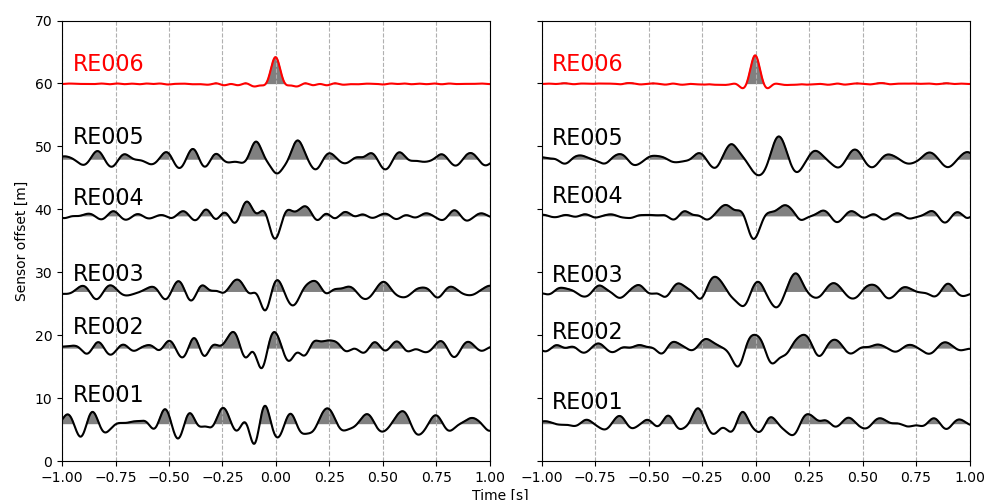

In [9]:
# Result DataFrame
db_res = pd.DataFrame()
# Figure
fig, axs = plt.subplots(1,len(results[sta_ref].keys()),sharex=True,sharey=True,dpi=100,figsize=(10,5))
fig.text(0.5, 0.0, 'Time [s]', ha='center')
axs[0].set_ylabel('Sensor offset [m]')
axs[0].set_xlim([-dstack,dstack])
axs[0].set_ylim([0,70])
for i, chan in enumerate(results[sta_ref].keys()):
    st_chan = st.select(component=chan)
    # Sort Stations on the building
    st_chan.sort()
    # Get FFT of Reference Station
    tr_ref = st_chan.select(station=sta_ref)[0]
    npts = tr_ref.stats.npts
    sr = tr_ref.stats.sampling_rate
    fft_ref, freqs_ref = calc_fft(tr_ref.data,npts,sr)
    # Start Calculating Deconvolution
    for tr_int in st_chan:
        # Get FFTs of station of interest
        fft_int, freqs_int = calc_fft(tr_int.data,npts,sr)
        # Deconvolution
        decon = deconvolve(fft_ref,fft_int,sp=sp,time_domain=True) #decon
        # Time signals of deconvolved station signal by using Tikhonov regularization method.
        sig_deco_r, t = interfer_tikhonov(decon,sr,r=r,dstack=dstack,time_domain=True)

        # Plotting
        height = building_height[tr_int.stats.station]
        y = (sig_deco_r*amplifier)+height
        if tr_int.stats.station == 'RE006':
            c = 'r'
        else:
            c = 'k'
        axs[i].plot(t,y,c=c)
        # Add RE Deconvolved signal
        if tr_int.stats.station != sta_ref:
            db_res[tr_int.stats.station+'.'+tr_int.stats.channel] = sig_deco_r
        axs[i].text(-dstack + 0.05,(sig_deco_r[10]*amplifier)+height+2,s=tr_int.stats.station,size=16,c=c)
        # Fill Between baseline to positive area
        where=np.array(y)>height
        axs[i].fill_between(t,height, y,where,color='grey')
        axs[i].grid(True,axis='x', linestyle='--')

# Fill out the DataFrame
db_res['Time'] = t
col = db_res.pop('Time')
db_res.insert(0, col.name, col)
db_res.to_csv('Data/deconvolution.csv',index=False)

fig.tight_layout()
fig.savefig('Figures/Deconvolution.png')

# Determination of Picks

In [10]:
db_res

,Time,RE001.EHN,RE002.EHN,RE003.EHN,RE004.EHN,RE005.EHN,RE001.EHE,RE002.EHE,RE003.EHE,RE004.EHE,RE005.EHE
0,-1.000,0.011608,0.003950,-0.008337,-0.006581,0.007552,0.006241,-0.007004,-0.006346,0.002843,0.005544
1,-0.998,0.013535,0.004037,-0.008344,-0.006962,0.007833,0.006423,-0.007787,-0.006539,0.002927,0.005469
2,-0.996,0.015471,0.004112,-0.008350,-0.007261,0.008065,0.006597,-0.008503,-0.006765,0.002960,0.005362
3,-0.994,0.017385,0.004179,-0.008355,-0.007475,0.008247,0.006756,-0.009138,-0.007022,0.002944,0.005225
4,-0.992,0.019248,0.004243,-0.008359,-0.007603,0.008377,0.006896,-0.009683,-0.007305,0.002878,0.005057
...,...,...,...,...,...,...,...,...,...,...,...
996,0.992,-0.022016,-0.000364,0.016667,-0.000445,-0.017836,-0.000560,-0.003136,-0.011780,-0.007044,0.021939
997,0.994,-0.022576,0.000319,0.017043,-0.001080,-0.017078,-0.001291,-0.002971,-0.011276,-0.006851,0.021710
998,0.996,-0.022949,0.000942,0.017331,-0.001671,-0.016235,-0.001968,-0.002866,-0.010764,-0.006503,0.021342
999,0.998,-0.023126,0.001495,0.017523,-0.002211,-0.015318,-0.002583,-0.002825,-0.010248,-0.006008,0.020836


In [11]:
def timepick(t,wfs,stas,chan,start_stop):
	global t_neg_pos, db_res
	"""Select start and end points"""
	nsta = wfs.shape[0]	
	
	fig, axes = plt.subplots(nrows=nsta, sharex=True, figsize=(9, 2*nsta), squeeze=False)
	axes = axes.flatten()
	axes[0].set_title(f'Channel: {chan}')
	st_axes = defaultdict(list)
	for i, tr in enumerate(wfs):
		axes[i].plot(t, tr, "k", label=stas[i])
		where=np.array(tr)>0
		axes[i].fill_between(t,0, tr,where,color='grey')
		axes[i].legend(loc='upper right')

		# Predetermined positions
		# Negative Part
		neg_idx = np.where(np.array(t)<0)[0]
		# Positive Part
		pos_idx = np.where(np.array(t)>=0)[0]
		# Global Maxima Method
		# Negative Values
		max_neg_val = max(tr[neg_idx])
		max_neg_t = t[np.argmax(tr[neg_idx], axis=0)]
		# Positive Values
		max_pos_val = max(tr[pos_idx])
		max_pos_t = t[np.where(tr == max_pos_val)[0][0]]

		axes[i].scatter(max_pos_t,max_pos_val,color='r')
		axes[i].scatter(max_neg_t,max_neg_val,color='r')

		# t_neg_pos = t_neg_pos.append({'Station':stas[i], 'Neg_t':max_neg_t, 'Pos_t':max_pos_t, 'Neg_v': max_neg_val, 'Pos_v':max_pos_val}, ignore_index=True)#
		t_neg_pos_tmp = pd.DataFrame([[stas[i], max_neg_t, max_pos_t, max_neg_val, max_pos_val]], columns=['Station','Neg_t','Pos_t','Neg_v','Pos_v'])
		t_neg_pos = pd.concat([t_neg_pos, t_neg_pos_tmp], ignore_index=True)
		# Edges of the graph
		ymin, ymax = np.min(tr)*1.2, np.max(tr)*1.2
		axes[i].set_xlim(t[0], t[-1])
		axes[i].set_ylim(ymin, ymax)
		axes[i].grid('on','both')
		
		st_axes[stas[i]].append(i)
		
	axes[-1].set_xlabel("Time (s)")
		
	ps = {}
	ss = {}
	def onselect(tmin, tmax, station, label):
		global t_neg_pos, db_res
		labelcolor = {'upgoing':'b','downgoing':'r'}
		for i in st_axes[station]:
			tmin_ontime = db_res.iloc[(db_res['Time']-tmin).abs().argsort()[:2]].Time.tolist()[0]
			min_idx = db_res.loc[db_res['Time'] == tmin_ontime].Time.index[0]
			tmax_ontime = db_res.iloc[(db_res['Time']-tmax).abs().argsort()[:2]].Time.tolist()[0]
			max_idx = db_res.loc[db_res['Time'] == tmax_ontime].Time.index[0]
			# t_neg_pos = t_neg_pos.append({'Station':stas[i], 'Neg_t':tmin, 'Pos_t':tmax, 'Neg_v': wfs[i][min_idx], 'Pos_v':wfs[i][max_idx]}, ignore_index=True)#
			t_neg_pos_tmp = pd.DataFrame([[stas[i], tmin, tmax, wfs[i][min_idx], wfs[i][max_idx]]], columns=['Station','Neg_t','Pos_t','Neg_v','Pos_v'])
			t_neg_pos = pd.concat([t_neg_pos, t_neg_pos_tmp], ignore_index=True)
			print(t_neg_pos)
			if i in ps:
				ps[i].pop(0).remove()
				ss[i].pop(0).remove()
			ps[i] = axes[i].plot([tmin, tmin], axes[i].get_ylim(), c=f'{labelcolor[label]}',linestyle='--')
			ss[i] = axes[i].plot([tmax, tmax], axes[i].get_ylim(), c=f'{labelcolor[label]}',linestyle='--')
			axes[i].vlines([tmin, tmin], ymin=axes[i].get_ylim()[0],ymax=axes[i].get_ylim()[1], color=f'{labelcolor[label]}',linestyle='--')
			axes[i].vlines([tmax, tmax], ymin=axes[i].get_ylim()[0],ymax=axes[i].get_ylim()[1], color=f'{labelcolor[label]}',linestyle='--')
			axes[i].text(tmin,0,s=str(round(tmin,2)))
			axes[i].text(tmax,0,s=str(round(tmax,2)))
			fig.canvas.draw()
	selectors = []
	class Index(object):
		ind = 0
		def down(self, event):
			for i in range(nsta):
				selectors.append(SpanSelector(axes[i], partial(onselect, station=stas[i], label='downgoing'), "horizontal", useblit=True))#,props=dict(alpha=0.5, facecolor="tab:red")))
		def up(self, event):
			for i in range(nsta):
				selectors.append(SpanSelector(axes[i], partial(onselect, station=stas[i], label='upgoing'),   "horizontal", useblit=True))#,props=dict(alpha=0.5, facecolor="tab:blue")))
	def change_up(event):
		bup.color = 'b'
		bup.hovercolor = bup.color
		fig.canvas.draw()
	def change_down(event):
		bdown.color = 'r'
		bdown.hovercolor = bdown.color
		fig.canvas.draw()
	
	callback = Index()
	axup = plt.axes([0.7, 0.05, 0.1, 0.035])
	bdown = Button(axup, 'Downgoing')
	bdown.on_clicked(callback.down)
	bdown.on_clicked(change_down)
	plt.show()
	return fig, axes, selectors, t_neg_pos

In [12]:
# Negative Part
neg_idx = db_res[db_res.Time < 0].index
# Positive Part
pos_idx = db_res[db_res.Time >= 0].index

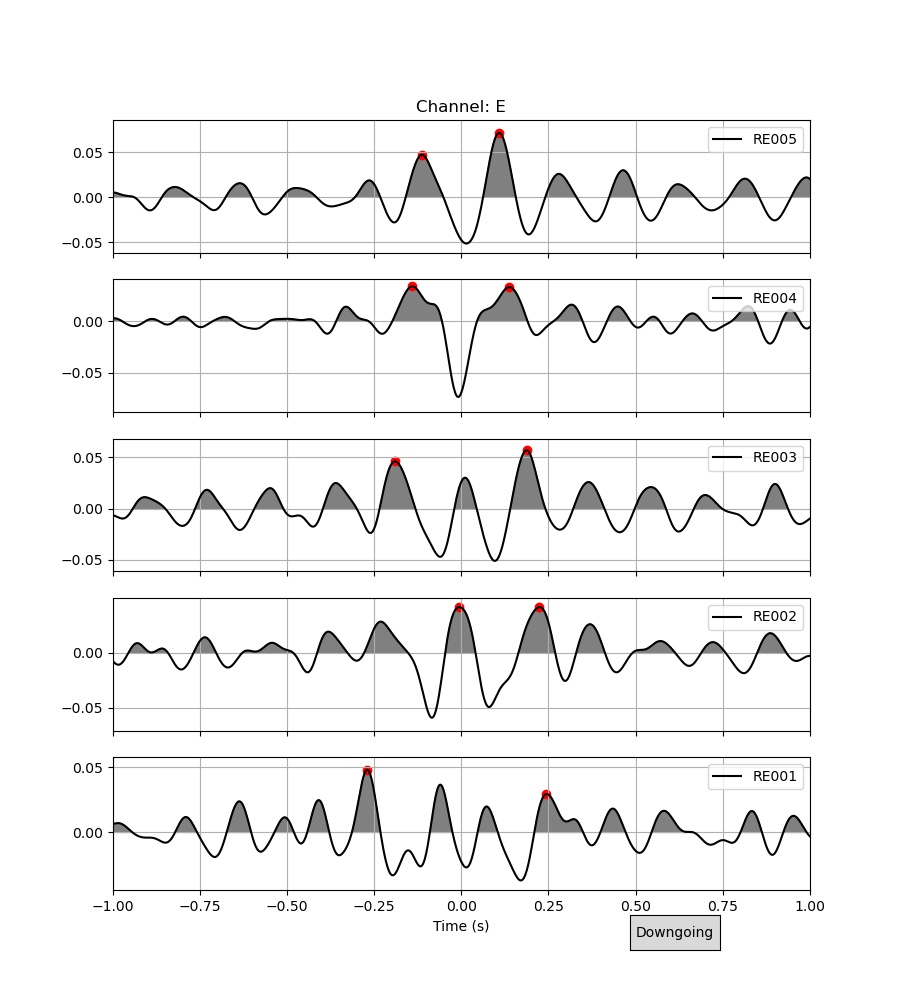

In [13]:
for chan in ['E']:#,'N'
    t_neg_pos = pd.DataFrame(columns=['Station', 'Neg_t' ,'Pos_t','Neg_v','Pos_v'])#
    stas = [];
    wfs = []
    
    for col in db_res.columns[1:][::-1]:
        sta = col.split('.')[0]
        if col[-1] == chan:	
            stas.append(sta)
            wfs.append(db_res[col])
            t = db_res[db_res.columns[0]].to_numpy()
    wfs = np.array(wfs)
    _,_,_, t_neg_pos = timepick(t,wfs,stas,chan,t_neg_pos)    

## Remove Automatic Picks with Manual Ones

In [17]:
t_neg_pos = t_neg_pos.drop_duplicates(['Station'], keep='last').sort_values('Station',ascending=False)
t_neg_pos.to_csv(f'Data/Deconvolution_{chan}.csv',index=False)

In [18]:
t_neg_pos

,Station,Neg_t,Pos_t,Neg_v,Pos_v
0,RE005,-0.112000,0.108000,0.047210,0.071656
1,RE004,-0.140000,0.138000,0.034080,0.033302
2,RE003,-0.190000,0.188000,0.045968,0.056781
5,RE002,-0.244444,0.228674,0.025291,0.041462
4,RE001,-0.270000,0.244000,0.048239,0.029521


# Calculate Velocity Structure

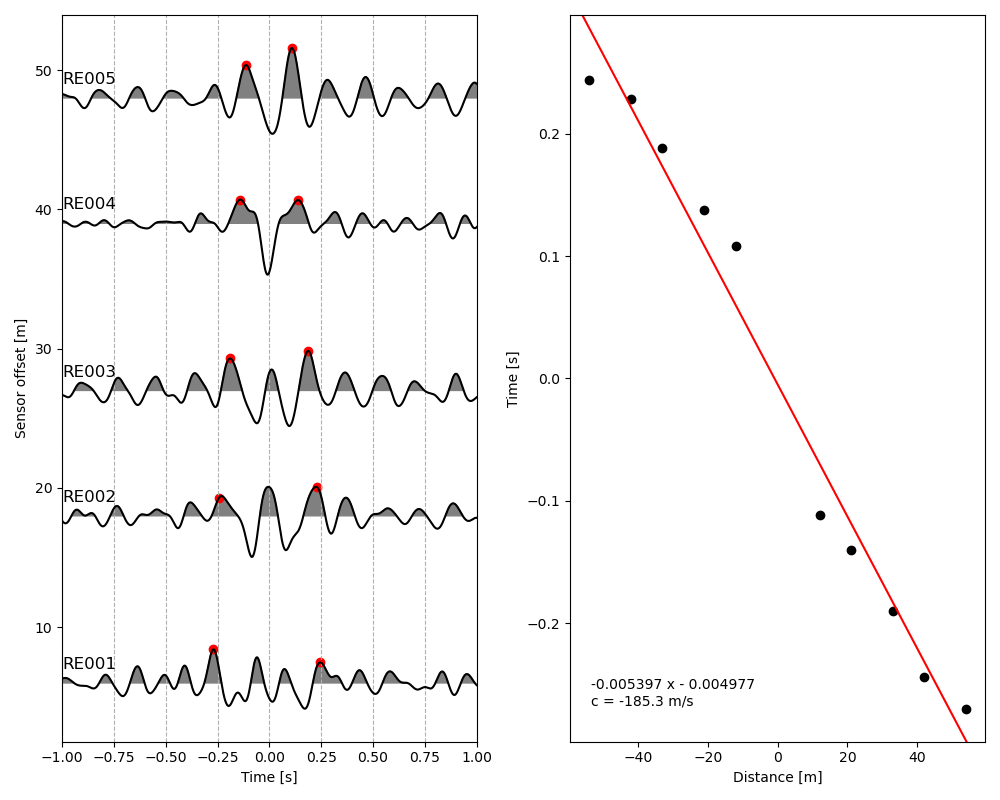

In [19]:
fig, axs = plt.subplots(1,2,dpi=100,figsize=(10,8))
for j,chan in enumerate(['E']):#results[sta_ref].keys()
	t_neg_pos = pd.read_csv(f'Data/Deconvolution_{chan}.csv')
	xs = []; ys = [];
	for col in db_res.columns[1:]:
		sta = col.split('.')[0]
		if col[-1] == chan:
			max_pos_val =t_neg_pos[t_neg_pos.Station == sta].Pos_v.iloc[0]
			max_neg_val = t_neg_pos[t_neg_pos.Station == sta].Neg_v.iloc[0]
			max_pos_t = t_neg_pos[t_neg_pos.Station == sta].Pos_t.iloc[0]
			max_neg_t = t_neg_pos[t_neg_pos.Station == sta].Neg_t.iloc[0]
			
			axs[1].scatter(building_height[sta]-building_height[sta_ref],max_pos_t,color='k')
			ys.append(building_height[sta]-building_height[sta_ref])
			xs.append(max_pos_t)
			axs[1].scatter(building_height[sta_ref]-building_height[sta],max_neg_t,color='k')
			ys.append(building_height[sta_ref]-building_height[sta])
			xs.append(max_neg_t)
			# Plot Deconvolved Signal
			amplifier = 50
			height = building_height[sta]
			y = (db_res[col]*amplifier)+height
			axs[0].plot(db_res.Time,y,c='k')
			# Fill Between baseline to positive area
			where=np.array(y)>height
			axs[0].fill_between(db_res.Time,height, y,where,color='grey')
			axs[0].grid(True,axis='x', linestyle='--')
			# Plot station name
			axs[0].text(-1.0,building_height[sta]+1,s=sta,size=12,c='k')
			# Put Maximum Locations on top
			axs[0].scatter(max_pos_t,(max_pos_val*amplifier)+height,color='r')
			axs[0].scatter(max_neg_t,(max_neg_val*amplifier)+height,color='r')
	# Fit a line
	coef = np.poly1d(np.polyfit(ys,xs, 1))
	xn = np.linspace(-60,60,100)
	axs[1].plot(xn,coef(xn),c='r')
	# Cosmetics
	xlim = max(ys)*1.1
	ylim = max(abs(np.array(xs)))*1.1
	axs[1].set_xlim([-xlim,xlim])
	axs[1].set_ylim([-ylim,ylim])
	axs[1].text(-xlim*0.9,-ylim+ylim*0.1,s=f'{coef}\nc = {round(1/(coef(1)-coef(0)),2)} m/s')
	axs[0].set_xlim([-1,1])
	axs[0].set_xlabel('Time [s]')
	axs[0].set_ylabel('Sensor offset [m]')
	axs[1].set_xlabel('Distance [m]')
	axs[1].set_ylabel('Time [s]')
	plt.tight_layout()
plt.savefig(f'Figures/velocity_structure_{chan}.png')
# plt.close(fig)